In [1]:
import scipy.io
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import glob
import os
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
from math import log
from joblib import Parallel, delayed
import multiprocessing

from skfeature.function.similarity_based import reliefF
from skfeature.utility.mutual_information import su_calculation

In [2]:
# csv = 'data/ARFF/CNS.csv'
csv = '../data/microarrays/data_toy_example/SPECTF_train.csv'

df = pd.read_csv(csv)
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['target'])

X_train = train_df[list(set(train_df.columns) - set(['target']))].to_numpy()
y_train = train_df[['target']].to_numpy().squeeze()

X_test = test_df[list(set(test_df.columns) - set(['target']))].to_numpy()
y_test = test_df[['target']].to_numpy().squeeze()

# INTERACT
https://www.public.asu.edu/~huanliu/papers/ijcai07.pdf

In [3]:
def interact(x, y,beta=1.):
    features = x
    classes = y
    scores = [su_calculation(features[:, feature_i], classes) for feature_i in range(features.shape[1])]
    
    for i in range(features.shape[1]):
        if i/features.shape[1] > beta:
            scores[i] = 1
    
    scores = np.array(scores)
    return scores

# Information Gain
https://github.com/Edouard360/python-ml/blob/master/5/infogain.py

In [4]:
def entropy(z):
    cl = np.unique(z)
    hz = 0
    for i in range(len(cl)):
        c = cl[i]
        pz = float(sum(z == c)) / len(z)
        hz = hz + pz * log(pz, 2)
    hz = -hz
    return hz


def infogain(x, y,beta=1.):
    '''
        x: features (data)
        y: output (classes)
    '''
    info_gains_par = np.ones(x.shape[1]) # features of x
    info_gains = np.ones(x.shape[1]) # features of x
    nrows = x.shape[0]
    # calculate entropy of the data *hy* with regards to class y

    hy = entropy(y)
    info_gains *= hy

    # ====================== Non-Parallel ================================

#     for i in tqdm(range(len(info_gains))):
#         xi_unique = np.unique(x[:, i])
#         #xi_unique = unique(array(x[:,i])[:,0])
#         for j in range(len(xi_unique)):
#             indexi = (xi_unique[j] == x[:, i])
#             #indexi = (xi_unique[j] == array(x[:,i])[:,0])
#             info_gains[i] -= entropy(y[indexi])*(sum(indexi)/nrows)

    # ======================   Parallel   ================================
    def calc_entropy_for_col(i):
        entropy_sum = 0
        xi_unique = np.unique(x[:, i])
        for j in range(len(xi_unique)):
            indexi = (xi_unique[j] == x[:, i])
            entropy_sum += entropy(y[indexi])*(sum(indexi)/nrows)
        return entropy_sum
    entropy_sum = Parallel(n_jobs=6)(delayed(calc_entropy_for_col)(i) for i in range(len(info_gains)))
    
    info_gains = info_gains - np.array(entropy_sum)
    
    # ======================         ================================
    
    for i in range(x.shape[1]):
        if i/x.shape[1] > beta:
            info_gains[i] = 1
    
    return info_gains

# ReliefF

https://epistasislab.github.io/scikit-rebate/using/

In [5]:
def relieff(x, y,beta=1.):
    reliefF_ranking = reliefF.reliefF(x, y)
    reliefF_scores = reliefF_ranking / len(reliefF_ranking)
    
    for i in range(x.shape[1]):
        if i/x.shape[1] > beta:
            reliefF_scores[i] = 1
    
    return reliefF_scores

# Ensemble of Filters

In [6]:
def ensemble_of_filters(x, y,beta=1.):
    infogain_scores = infogain(x, y,beta)
    interact_scores = interact(x, y,beta)
    reliefF_scores = relieff(x, y,beta)
    
    ensemble = (infogain_scores + interact_scores + reliefF_scores) / 3
    
    return ensemble

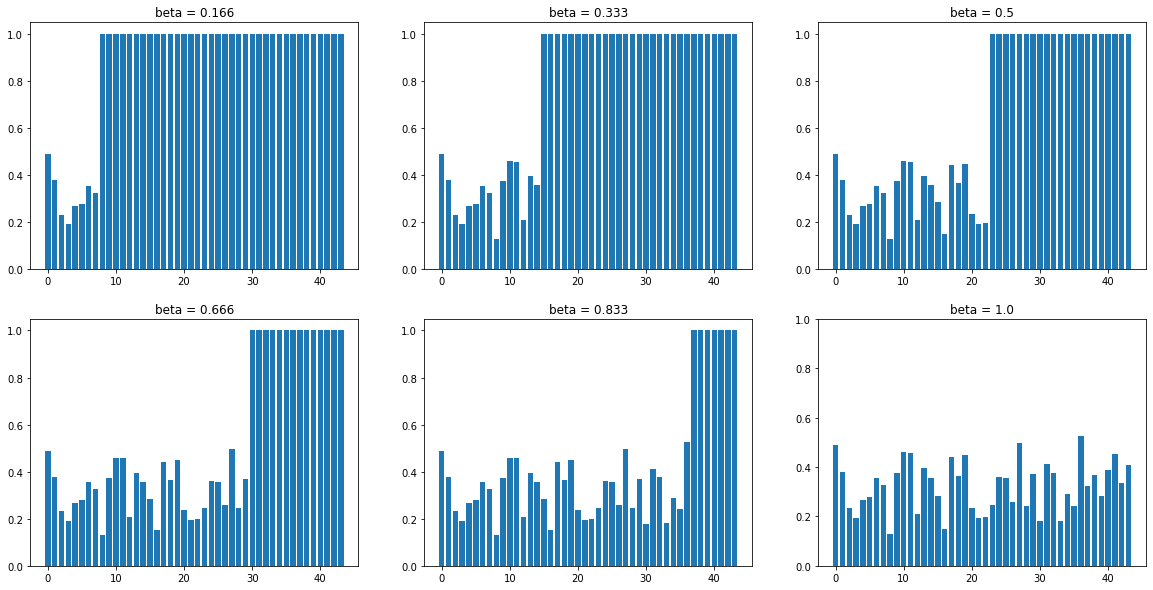

In [7]:
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(20,10))

for i in range(cols*rows):
    r = i // cols
    c = i %  cols
    beta = (i+1) / (cols*rows)
    plt.ylim(0, 1)
    axs[r,c].set_xticks(list(range(0,44,10)))
    axs[r,c].set_title(f'beta = {str(beta)[0:5]}')
    axs[r,c].bar([str(i) for i in range(44)], ensemble_of_filters(X_train, y_train, beta=beta))